In [1]:
# Import required libraries
import pandas as pd
from pathlib import Path
from pandas.tseries.offsets import DateOffset

In [2]:
trading_df = pd.read_csv(
    Path("hailmarry.csv"), 
    index_col="time", 
    infer_datetime_format=True, 
    parse_dates=True)


In [3]:
# Review the Data-Frame
trading_df.head()

,close,volume
time,,
2017-06-30,100.050,21662403.44
2017-07-03,100.332,21716419.04
2017-07-05,101.332,21746020.64
2017-07-06,100.496,21770020.64
2017-07-07,100.656,21806020.64


In [4]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,close,volume,actual_returns
time,,,
2017-07-03,100.332,21716419.04,0.002819
2017-07-05,101.332,21746020.64,0.009967
2017-07-06,100.496,21770020.64,-0.008250
2017-07-07,100.656,21806020.64,0.001592
2017-07-10,100.860,21816020.64,0.002027


,close,volume,actual_returns
time,,,
2022-06-24,169.184,"11,720,030.40",0.024935
2022-06-27,168.922,"11,717,430.40",-0.001549
2022-06-28,166.246,"11,719,510.40",-0.015842
2022-06-29,167.314,"11,797,030.40",0.006424
2022-06-30,165.906,"11,830,290.40",-0.008415


In [5]:
# Define a window size of 4
short_window = 4

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

In [6]:
# Define a window size of 100
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()

In [7]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

In [8]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
time,,
2017-11-21,107.5280,101.31438
2017-11-22,107.6850,101.38942
2017-11-24,107.7195,101.45248
2017-11-27,107.7460,101.52374
2017-11-28,107.9680,101.60494


,sma_fast,sma_slow
time,,
2022-06-24,164.6785,175.23256
2022-06-27,166.4760,175.04506
2022-06-28,167.3550,174.81416
2022-06-29,167.9165,174.63840
2022-06-30,167.0970,174.41908


In [9]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

In [10]:
# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [11]:
# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [12]:
# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

In [13]:
#TEST&SPLIT

In [14]:
# Select the start of the training period
training_begin =  X.index.min()

# Display the training begin date
print(training_begin)

2017-11-21 00:00:00


In [15]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)
X.index.min() + DateOffset(months=3)
# Display the training end date
print(training_end)

2018-02-21 00:00:00


In [16]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
time,,
2017-11-21,107.5280,101.31438
2017-11-22,107.6850,101.38942
2017-11-24,107.7195,101.45248
2017-11-27,107.7460,101.52374
2017-11-28,107.9680,101.60494


In [17]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
time,,
2018-02-21,107.8530,107.30192
2018-02-22,107.8025,107.36686
2018-02-23,108.2510,107.44774
2018-02-26,109.0385,107.53200
2018-02-27,109.5910,107.60666


In [18]:
#STANDARDIZE
# Imports
from sklearn.preprocessing import StandardScaler

In [19]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [20]:
#SVM Modeling

In [21]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [22]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [23]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.55      0.84      0.67        32
         1.0       0.62      0.27      0.37        30

    accuracy                           0.56        62
   macro avg       0.58      0.56      0.52        62
weighted avg       0.58      0.56      0.52        62



In [24]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [25]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61       486
         1.0       1.00      0.00      0.00       618

    accuracy                           0.44      1104
   macro avg       0.72      0.50      0.31      1104
weighted avg       0.75      0.44      0.27      1104



In [26]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
time,,,
2018-02-21,-1.0,0.001375,-0.001375
2018-02-22,-1.0,0.000575,-0.000575
2018-02-23,-1.0,0.017469,-0.017469
2018-02-26,-1.0,0.009623,-0.009623
2018-02-27,-1.0,-0.007149,0.007149


<AxesSubplot:xlabel='time'>

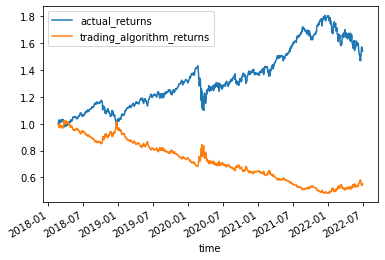

In [27]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [28]:
#LOGISTICREGRESSION
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [29]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

In [30]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [31]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [32]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.56      0.72      0.63        32
         1.0       0.57      0.40      0.47        30

    accuracy                           0.56        62
   macro avg       0.57      0.56      0.55        62
weighted avg       0.57      0.56      0.55        62



In [33]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [34]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.99      0.61       486
         1.0       0.68      0.02      0.04       618

    accuracy                           0.45      1104
   macro avg       0.56      0.50      0.33      1104
weighted avg       0.58      0.45      0.29      1104



In [35]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.44      0.99      0.61       486
         1.0       0.68      0.02      0.04       618

    accuracy                           0.45      1104
   macro avg       0.56      0.50      0.33      1104
weighted avg       0.58      0.45      0.29      1104



In [36]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61       486
         1.0       1.00      0.00      0.00       618

    accuracy                           0.44      1104
   macro avg       0.72      0.50      0.31      1104
weighted avg       0.75      0.44      0.27      1104

